# Benchmarking

> Comparing the DRSA model to some other baseline models.

* *Note*: with the drsa, we can use embeddings. With the other models we cannot.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# import torch.nn.functional as F

# from drsa.functions import event_time_loss, event_rate_loss
from drsa.model import DRSA

from pull_the_pitcher.data.pipeline import add_targets
from pull_the_pitcher.metrics import preds_histogram, print_all_metrics

/Users/collinprather/anaconda3/envs/orioles/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
embedding_cols = ["pitcher"] # ["game_pk",  "game_type", "pitcher_team_year"]
feature_cols = ["post_bat_score", "score_diff", "end_inning", "inning", "postouts", "cum_sb_ratio",
                "times_thru_order", "post_total_runners", "tying_run_on", "pitch_total", "post_opposite_hand",
                "walk", 'walk_cumsum', 'strikeout_cumsum', 'home_run_cumsum', 'bases_cumsum']
cols = embedding_cols + feature_cols

In [3]:
train = pd.read_csv("../data/processed/train_2016_2017_2018.csv")
val = pd.read_csv("../data/processed/val_2016_2017_2018.csv")
test = pd.read_csv("../data/processed/test_2019.csv")

with open("../data/processed/mappers_2016_2017_2018_2019.pkl", "rb") as f:
    mappers = pickle.load(f)
    
with open("../data/processed/scaler_2016_2017_2018_2019.pkl", "rb") as f:
    scaler = pickle.load(f)
    
# scaling test data (as tuned on training data)
test[feature_cols] = scaler.transform(test[feature_cols])

## Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
X_train, X_test, y_train, y_test = train[feature_cols], test[feature_cols], train["pulled"], test["pulled"] 

In [6]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train);

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     45155
         1.0       0.67      0.21      0.32      2034

    accuracy                           0.96     47189
   macro avg       0.82      0.60      0.65     47189
weighted avg       0.95      0.96      0.95     47189

mean plate appearance diff: 0.22026
mean target diff: 0.02861


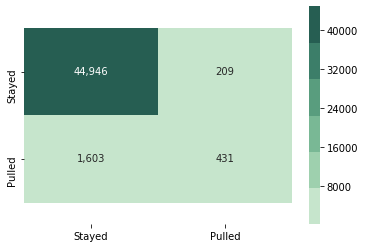

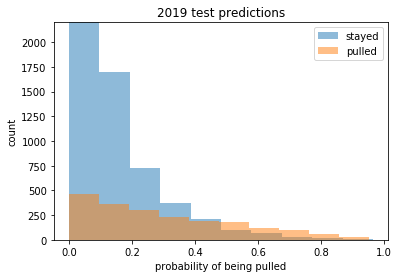

In [7]:
print_all_metrics(y_test, log_reg.predict_proba(X_test)[:, 1], thresh=0.5)

In [8]:
for feature, coef in zip(feature_cols, log_reg.coef_[0]):
    print(f"{feature}: {round(coef, 4)}")

post_bat_score: 0.2613
score_diff: 0.0099
end_inning: -1.3929
inning: 0.3714
postouts: 0.9072
cum_sb_ratio: -0.0739
times_thru_order: 0.3758
post_total_runners: 0.3128
tying_run_on: -0.0121
pitch_total: 2.5259
post_opposite_hand: 0.0299
walk: 0.0501
walk_cumsum: -0.0003
strikeout_cumsum: -0.1353
home_run_cumsum: 0.0789
bases_cumsum: 0.073


## Gradient-Boosted Tree

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
gbt = GradientBoostingClassifier(subsample=0.5)
gbt.fit(X_train, y_train);

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     45155
         1.0       0.67      0.27      0.39      2034

    accuracy                           0.96     47189
   macro avg       0.82      0.63      0.68     47189
weighted avg       0.96      0.96      0.96     47189

mean plate appearance diff: 0.17355
mean target diff: 0.0288


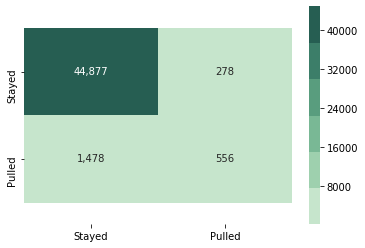

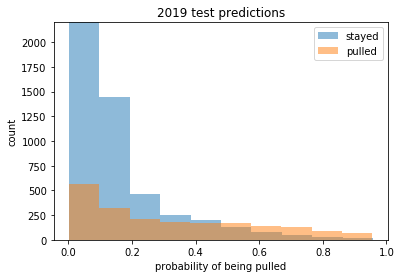

In [11]:
print_all_metrics(y_test, gbt.predict_proba(X_test)[:, 1], thresh=0.5)

## DRSA

In [12]:
def get_starts(df, cols, y_col="last_batter"):
    """
    Given a dataframe with many pitcher outings stacked on top of one another,
    this function extracts each individual outing
    """
    start_stats = np.array(df[cols])
    removal = np.array(df[y_col])
    pulled_idx = np.nonzero(removal)[0]
    stats = []
    for i in range(pulled_idx.shape[0]):
        if i == 0:
            stat = start_stats[: pulled_idx[i] + 1]
        else:
            stat = start_stats[pulled_idx[i - 1] + 1: pulled_idx[i] + 1]

        stats.append(stat)
    return stats
    
def front_pad(starts):
    """
    starts is a list of np arrays. Each has a shape of
    (# batters faced, # features)
    """
    n_features = starts[0].shape[1]
    longest = np.max([start.shape[0] for start in starts])
    padded_starts = []
    for start in starts:
        length = start.shape[0]
        difference = longest - length
        pad = np.zeros((difference, n_features)) # this also just puts a zero in for the target
        padded_start = np.vstack([pad, start])
        padded_starts.append(padded_start)
    return padded_starts

In [13]:
# quick dropping of a few unneeded columns
train = train.drop(columns=['game_type', 'pitcher_team_year'])
test = test.drop(columns=['game_type', 'pitcher_team_year'])

In [14]:
# getting each individual start
train_starts = get_starts(train, cols=cols, y_col="pulled")
test_starts = get_starts(test, cols=cols, y_col="pulled")

# adding targets back
train_starts = add_targets(train_starts)
test_starts = add_targets(test_starts)

# front-padding for parallelized training
padded_train_starts = front_pad(train_starts)
padded_test_starts = front_pad(test_starts)

In [15]:
class PTPDataset(Dataset):
    def __init__(self, starts):
        """
        starts is a list of np arrays. Each has a shape of
        (# batters faced, # features)
        """
        self.starts = starts
    
    def __len__(self):
        return len(self.starts)
    
    def __getitem__(self, idx):
        # ignoring first col, which is game_pk (unique identifier for each game)
        X = torch.tensor(self.starts[idx][:, 1:-1].astype(float), dtype=torch.double)
        y = torch.tensor(self.starts[idx][:, -1], dtype=torch.double).unsqueeze(-1)
        return X, y

In [16]:
# instantiating datasets and data loaders
train_ds = PTPDataset(padded_train_starts)
test_ds = PTPDataset(padded_test_starts)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256)

In [17]:
def save_model(m, p): torch.save(m.state_dict(), p)
def load_model(m, p): m.load_state_dict(torch.load(p))

In [18]:
# getting embeddings ready
n_pitchers = 270
pitcher_emb_size = 20
pitcher_embeddings = nn.Embedding(n_pitchers, pitcher_emb_size)

ptp_embeddings = [pitcher_embeddings]

# initializing model
drsa = DRSA(n_features=16,
            hidden_dim=20,
            n_layers=5,
            embeddings=ptp_embeddings,
            output_size=1,
            LSTM_dropout=0.05,
            Linear_dropout=0.1)

In [19]:
! ls ../models/

06-17-20_DRSA_2017_2018_2019_loss_0.084.pth
06-17-20_DRSA_2017_2018_2019_loss_1.7337.pth
07-07-20_DRSA_2017_2018_2019_loss_0.3017.pth
07-10-20_DRSA_2016_2017_2018_2019_loss_2.6303.pth


In [ ]:
## my
load_model(drsa, f"../models/07-10-20_DRSA_2016_2017_2018_2019_loss_2.6303.pth")
drsa.eval()

In [ ]:
## my
X, y = next(iter(valid_dl))

In [ ]:
x = X[:1, :, :]
x.shape

In [ ]:
new_ab = torch.tensor([[[1.0000,  0.0000,  0.0000,  8.0000,  0.0000,  0.7168,  2.7777,
           0.0000,  0.0000, 91.0000,  0.0000,  0.0000,  2.0000,  4.0000,
           1.0000,  7.0000]]])
new_ab.shape

In [ ]:
x_added = torch.cat([x.float(), new_ab], dim=1)
x_added.shape

In [ ]:
## my
drsa.eval()
h = drsa(x_added).view(-1, 1)
h_c = 1 - h

p = []
for i in range(h.shape[0]):
    p.append(h_c[:i, :].log().sum().exp() * h[i, :])

In [ ]:
p, h

In [22]:
# loading up saved model
load_model(drsa, f"../models/07-10-20_DRSA_2016_2017_2018_2019_loss_2.6303.pth")
drsa.eval()

# organizing val preds in df
test_features = np.concatenate(padded_test_starts, axis=0)
preds = []
for X_test, y_test in test_dl:
    pred = drsa(X_test).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
test_df = pd.DataFrame(np.hstack([test_features, preds]), columns=cols+["last_batter", "pred"])
    
# organizing train preds in df
train_features = np.concatenate(padded_train_starts, axis=0)
preds = []
for X_train, y_train in train_dl:
    pred = drsa(X_train).squeeze(0).detach().numpy().reshape(-1, 1)
    preds.append(pred)
preds = np.concatenate(preds, axis=0)
train_df = pd.DataFrame(np.hstack([train_features, preds]), columns=cols+["last_batter", "pred"])

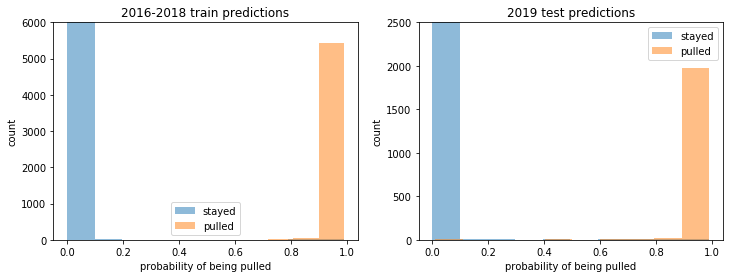

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
preds_histogram(train_df["last_batter"], train_df["pred"], ax=ax[0], ylim = (0, 6000), title="2016-2018 train predictions")
preds_histogram(test_df["last_batter"], test_df["pred"], ax=ax[1], ylim=(0, 2500), title="2019 test predictions")

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     71190
         1.0       0.99      0.99      0.99      2034

    accuracy                           1.00     73224
   macro avg       0.99      1.00      0.99     73224
weighted avg       1.00      1.00      1.00     73224

mean plate appearance diff: 0.01032
mean target diff: 0.00085


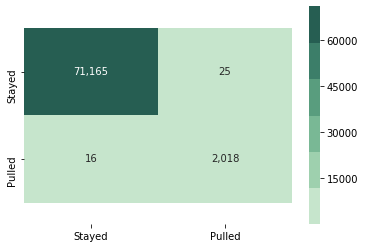

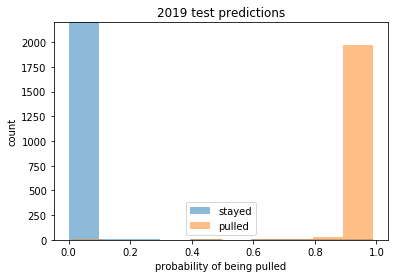

In [26]:
print_all_metrics(test_df["last_batter"], test_df["pred"], thresh=0.5)